
### Отчет по исследованию матричных игр

**Выполнил**: Решетников Егор Алексеевич (ПМ-41) (reshetnikov.e.a@mail.ru)

**Преподаватель**: Гурьянов М.А., кафедра ВМ-1

# Глава 2 Математическая модель и решение задач в частных случаях

## Теоретические сведения

**Чистая стратегия** даёт полную определённость, каким образом игрок продолжит игру. В частности, она определяет результат для каждого возможного выбора, который игроку может придётся сделать. Пространством стратегий называют множество всех чистых стратегий, доступных данному игроку.

**Смешанная стратегия** является указанием вероятности каждой чистой стратегии.

**Утверждение 1**:
Оптимальная стратегия игрока А в игре данного вида (2 x N) находится как самая высокая точка нижней границы всех линий страгий (на рисунке зеленые)
$$
A = [x, (1-x)]
$$

Координата Y максимальной крайней точки обозначает цену игры

**Утверждение 2**: Две стратегии игрока B, образующие на пересечении точку оптимальной стратегии игрока А являются единственными полезными стратегиями игрока B. (тоесть это единственные стратегии которые будет использовать игрок B).

**Утверждение 3**:
Оптимальнся стратегия игрока B ищется исходя из системы уравнений:

$$
\begin{cases}
b_i \cdot (x,1-x) = V\\
b_j \cdot (x,1-x) = V
\end{cases}
$$

Или 

$$
\begin{cases}
p \cdot G(1,i) + (1-p) \cdot G(1,j)  = V\\
p \cdot G(2,i) + (1-p) \cdot G(2,j)  = V\\
\end{cases}
$$

## Задание 1

Написать функцию которая на вход принимает матрицу игры G и
1. Рисует графическую интрепретацию игры
2. Находит координаты точки оптимальной игры и вычисляет оптимальную стратегию игрока А и цену игры

Способы решения игры графически:

* Перебрать значения координаты X  с шагом $\epsilon$ и для каждого значения выбрать значение игры как минимум из всех линейных функций в данной точке - **Численное решение**
* Перебрать все пары стратегий игрока B, найти их точки пересечения и выбрать точку перечения А) максимальную и Б находящуюся под невыбранными линиями. Из точек удовлетворяющийх условию выбирается максимальная по координате Y - **Аналитическое решение**
* Метод Симплекса: Составляется список вершин, образующих ломаную линию под всеми стратегиями игрока B, из этих вершин выбирается максимальная- **Аналитическое решение**
* Перебор матриц игры - выбираем случайным образом два столбца, находим оптимальные стратегии и **проверяем статистическим моделированием - делаем 100000 итераций, на каждой из них выбирая случайне стратегии А и Б и проверяя что цена игры не стала лучше** - **Аналитический способ**.

In [1]:
# Код на Питоне
import numpy as np
import matplotlib.pyplot as plt

# Получить точку пересечения по двум стратегиям
# G - матрица игры
# i, j - индексы столбца, соотвествующие стратегии Игрока 2
def get_cross_point(G: np.ndarray, i: int, j: int):
    # Если прямые параллельны
    if (G[1][i] - G[0][i]) / (G[1][j] - G[0][j]) == 1:
        # Если они совпадают, вернем первую точку прямой
        if G[0][i] == G[1][i]:
            return 0
        else:
            return None

    x = (G[0][j] - G[0][i]) / (G[1][i] - G[0][i] - G[1][j] + G[0][j])
    y = (G[1][i] - G[0][i]) * x + G[0][i]
    return np.array([x, y])

# Получить элементы вида [i, j, [x, y]], где [x, y] - кооридинаты точки пересечения i и j стратегии Игрока 2
def get_all_cross_points(G: np.ndarray):
    result = []
    for i in range(G.shape[1]):
        for j in range(G.shape[1]):
            if i == j:
                continue

            # Т.к. пересения i,j то же самое, что пересечение j,i
            is_point_already_added = False
            for item in result:
                if item[0] == j and item[1] == i:
                    is_point_already_added = True
                    break
            if is_point_already_added:
                continue

            point = get_cross_point(G, i, j)
            
            if point is None:
                continue
            
            [x, y] = point

            # Нам интересны только те точки пересечения, которые находятся на отрезке [0; 1]
            if x >= 0 and x <= 1:
                result.append([i, j, [x, y]])
    # Соритируем точки пересечения по x
    return sorted(result, key = lambda item: item[2][0])

def get_optimal_first_player_strategy(G):
    filtered_points = []
    previous_point = 0
    
    # Для каждого отрезка между двумя точками пересчениями
    for [i, j, [x, y]] in get_all_cross_points(G):
        # Выбираем его середину
        middle = previous_point + (x - previous_point) / 2
        
        # Находим прямую, которая находится ниже всех для этого отрезка
        min_i = 0
        min_value = 2**15
        for k in range(G.shape[1]):
            current_value = (G[1][k] - G[0][k]) * middle + G[0][k]
            if current_value < min_value:
                min_i = k
                min_value = current_value

        # Если точка пересчения принадлежит найденной прямой, запоминаем точку пересечния
        if min_i == i or min_i == j:
            filtered_points.append([i, j, [x, y]])
        previous_point = x
    return sorted(filtered_points, key = lambda item: item[2][1], reverse=True)[0]

def draw_game(G):
    plt.plot([-0.1, 1.1],[0, 0],'b')
    plt.plot([0,0],[0,10],'b')
    plt.plot([1,1],[0,10],'b')

    for item in get_all_cross_points(G):
        plt.plot(item[2][0], item[2][1], 'g*')
    
    [i, j, [x, y]] = get_optimal_first_player_strategy(G)
    plt.plot(x, y, 'r*')

    for k in range(len(G[0])):
        plt.plot([0],G[0][k],'g*')
        plt.plot([1],G[1][k],'g*')
        line_color = 'r' if i == k or j == k else 'g'
        plt.plot([0,1],[G[0][k],G[1][k]], line_color)

    plt.grid(True)
    plt.show()
    return [i, j, [x, y]]

G = [[ 3  5  4  6]
 [ 8  6 10  4]]


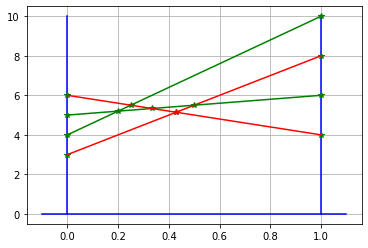

Оптимальными стратегиями Игрока 1 являются: 0 и 3.
С вероятностью = 0.42857.
Цена игры 5.14286.


In [2]:
# Код на Питоне
G = np.array([[3, 5, 4, 6],
              [8, 6, 10, 4]])
print("G = {0}".format(G))

[i, j, [x, y]] = draw_game(G)
print("Оптимальными стратегиями Игрока 1 являются: {0} и {1}.\nС вероятностью = {2:.5f}.\nЦена игры {3:.5f}.".format(i, j, x, y))

## Задание 2

Решить игру и найти оптимальную стратегию игрока B

Для решения задания 2 воспользуемся результатами задания 1 и утверждением 3.

In [3]:
# Код на Питоне
A = np.array([[(G[0][i] - G[0][j]), -1],
              [(G[1][i] - G[1][j]), -1]])
f = np.array([-G[0][j], -G[1][j]])

[x, y] = np.linalg.solve(A, f)
print("Оптимальными стратегиями Игрока 2 являются: {0} и {1}.\nС вероятностью = {2:.5f}.\nЦена игры {3:.5f}.".format(i, j, x, y))

Оптимальными стратегиями Игрока 2 являются: 0 и 3.
С вероятностью = 0.28571.
Цена игры 5.14286.
